<a href="https://colab.research.google.com/github/RuobingBai/Detection-of-Vulnerable-Individuals-Using-NLP-of-Helpline-Records/blob/main/Baseline_model_Using_structured_data_as_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load Packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Set up for where to save the figures
import os
PROJECT_ROOT_DIR = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## **Load Data**

In [ ]:
import time
start = time.time()
#read data in chunks of 1 million rows at a time
chunk = pd.read_csv('Helpline data.csv',chunksize=1000000)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")
data = pd.concat(chunk)

Read csv with chunks:  0.010251998901367188 sec


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   IP Address (hashed)       12672 non-null  object
 1    Contact ID (hashed)      20460 non-null  object
 2   Case Number               20460 non-null  int64 
 3   Case Origin               20460 non-null  object
 4   Case Reason               15603 non-null  object
 5   Subject                   20325 non-null  object
 6   Description               17572 non-null  object
 7   Break Confidentiality?    20460 non-null  int64 
 8   Main Issue Category       15147 non-null  object
 9   Issues mentioned          15163 non-null  object
 10  Initial Feeling           16096 non-null  object
 11  Age                       17830 non-null  object
 12  County                    5932 non-null   object
 13  Region                    17744 non-null  object
 14  Gender                

## **Structured Data Preprocessing**

1. Check the number of missing values and drop the columns which have too many missing values

2. Fill in the missing values properly

3. Encode the categorical data

4. Balance data in "Break Confidentiality?"

5. Split the dataset into training and test dataset

6. Identify X and Y

In [ ]:
# Percentage of missing values in all columns
column_list = data.columns.tolist()

# List those columns with percentage of missing values
round((data.isnull().sum()/20461),3)

IP Address (hashed)         0.381
 Contact ID (hashed)        0.000
Case Number                 0.000
Case Origin                 0.000
Case Reason                 0.237
Subject                     0.007
Description                 0.141
Break Confidentiality?      0.000
Main Issue Category         0.260
Issues mentioned            0.259
Initial Feeling             0.213
Age                         0.129
County                      0.710
Region                      0.133
Gender                      0.134
Sexuality                   0.942
Ethnicity                   0.130
Disabled                    0.944
Religion                    0.943
Employment Status           0.946
Date/Time Opened            0.000
How do they prefer help?    0.175
What type of help?          0.172
Were signposts offered?     0.260
dtype: float64

**Columns considered include "Break Confidentiality", "Main Issue Category", "Age", "Region", "Gender".**

In [ ]:
data1 = data[["Break Confidentiality?", "Main Issue Category", "Age", "Region", "Gender"]]

In [ ]:
data1.head()

,Break Confidentiality?,Main Issue Category,Age,Region,Gender
0,0,Mental Health,26+,Wales,Male
1,0,Mental Health,20,London,Female
2,0,Mental Health,15,Yorkshire and the Humber,Female
3,0,Mental Health,18,North East England,Male
4,0,Mental Health,24,Yorkshire and the Humber,Female


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Break Confidentiality?  20460 non-null  int64 
 1   Main Issue Category     15147 non-null  object
 2   Age                     17830 non-null  object
 3   Region                  17744 non-null  object
 4   Gender                  17718 non-null  object
dtypes: int64(1), object(4)
memory usage: 799.3+ KB


In [ ]:
# "Break confidentiality"
data1["Break Confidentiality?"].value_counts()

0    20085
1      375
Name: Break Confidentiality?, dtype: int64

In [ ]:
# Encode this column
# data1["Main Issue Category"] = data1["Main Issue Category"].fillna(method='ffill')

## Dealing with missing values
def MissingRandom(dataframe):
    import random
    from collections import Counter
    def fillcolumn(ser):
        cna=len(ser[ser.isna()])
        l=ser[ser.notna()]
        d=Counter(l)    
        m=random.choices(list(d.keys()), weights = list(d.values()), k=cna)
        ser[ser.isna()]=m
        return ser
        
    for i in dataframe.columns:
      dataframe[i]=fillcolumn(dataframe[i])
    return dataframe

In [ ]:
MissingRandom(data1)

,Break Confidentiality?,Main Issue Category,Age,Region,Gender
0,0,Mental Health,26+,Wales,Male
1,0,Mental Health,20,London,Female
2,0,Mental Health,15,Yorkshire and the Humber,Female
3,0,Mental Health,18,North East England,Male
4,0,Mental Health,24,Yorkshire and the Humber,Female
...,...,...,...,...,...
20455,0,None specified,12,London,Male
20456,0,Mental Health,0-6,Channel Islands,Male
20457,0,None specified,15,Channel Islands,Male
20458,0,Sex & Relationships,15,Channel Islands,Male


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Break Confidentiality?  20460 non-null  int64 
 1   Main Issue Category     20460 non-null  object
 2   Age                     20460 non-null  object
 3   Region                  20460 non-null  object
 4   Gender                  20460 non-null  object
dtypes: int64(1), object(4)
memory usage: 799.3+ KB


##### Main Issue Category

In [ ]:
data1["Main Issue Category"] = data1["Main Issue Category"].astype(str)
# "Main issue category"
data1["Main Issue Category"].value_counts()

Mental Health          11951
None specified          3829
Sex & Relationships     2301
Housing                  690
Work & Study             615
Your Body                451
Money                    225
Crime & Safety           207
Drink & Drugs            156
Travel & Lifestyle        35
Name: Main Issue Category, dtype: int64

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import LabelBinarizer
except ImportError:
    from future_encoders import OneHotEncoder,OneHotEncoder, LabelEncoder, LabelBinarizer # Scikit-Learn < 0.20
    
label_encoder = LabelEncoder()
data1[['Main Issue Category']] = label_encoder.fit_transform(data1[['Main Issue Category']])

In [ ]:
data1["Main Issue Category"].value_counts()

3    11951
5     3829
6     2301
2      690
8      615
9      451
4      225
0      207
1      156
7       35
Name: Main Issue Category, dtype: int64

##### Age

In [ ]:
# "Age"
data1["Age"].value_counts()

19                   1978
We didn't ask        1698
20                   1607
18                   1548
21                   1546
22                   1472
23                   1435
17                   1418
16                   1349
24                   1186
15                   1078
26+                   985
14                    839
25                    678
13                    548
Prefer not to say     480
12                    314
11                    156
10                     87
0-6                    33
9                      19
8                       4
7                       2
Name: Age, dtype: int64

In [ ]:
#  Replace "26+","0-6", with "26" and "6"
data1["Age"] = data1["Age"].replace(["26+","0-6"],["26","6"])

# Fill "We didnt ask" with NaN
data1["Age"] = data1["Age"].replace("We didn't ask", np.NaN)

# Fill missing values with foward filling
data1["Age"] = data1["Age"].fillna(method='ffill')

# Fill "prefer not to say" with a numerical value
data1["Age"] = data1["Age"].replace(["Prefer not to say"],["30"])

In [ ]:
data1["Age"] = data1["Age"].astype(int)
series = pd.cut(data1["Age"], [6,12,18,24,30,36])
series

0        (24.0, 30.0]
1        (18.0, 24.0]
2        (12.0, 18.0]
3        (12.0, 18.0]
4        (18.0, 24.0]
             ...     
20455     (6.0, 12.0]
20456             NaN
20457    (12.0, 18.0]
20458    (12.0, 18.0]
20459    (12.0, 18.0]
Name: Age, Length: 20460, dtype: category
Categories (5, interval[int64]): [(6, 12] < (12, 18] < (18, 24] < (24, 30] < (30, 36]]

In [ ]:
age_bucket = np.array(series)
age_bucket

array([Interval(24.0, 30.0, closed='right'),
       Interval(18.0, 24.0, closed='right'),
       Interval(12.0, 18.0, closed='right'), ...,
       Interval(12.0, 18.0, closed='right'),
       Interval(12.0, 18.0, closed='right'),
       Interval(12.0, 18.0, closed='right')], dtype=object)

In [ ]:
# Change the column to be bucket-style
data1["Age"]=age_bucket

In [ ]:
data1["Age"] = data1["Age"].fillna("Prefer not to say")

In [ ]:
# Transform the data type (interval) into strings
data1["Age"] = data1["Age"].astype(str)
data1["Age"].value_counts()

(18.0, 24.0]         10144
(12.0, 18.0]          7244
(24.0, 30.0]          2417
(6.0, 12.0]            621
Prefer not to say       34
Name: Age, dtype: int64

In [ ]:
# Encode label
data1[['Age']] = label_encoder.fit_transform(data1[['Age']])

In [ ]:
data1["Age"].value_counts()

1    10144
0     7244
2     2417
3      621
4       34
Name: Age, dtype: int64

##### Region

In [ ]:
data1["Region"].value_counts()

London                          2800
Didn't Ask                      2537
South East England              2272
North West England              1609
South West England              1460
Prefer not to say               1432
West Midlands                   1377
East Midlands                   1237
Yorkshire and the Humber        1237
East of England                 1027
Scotland                         999
Wales                            811
North East England               774
Outside of the UK (Overseas)     482
Northern Ireland                 272
Isle of Man                       92
Channel Islands                   42
Name: Region, dtype: int64

In [ ]:
# Deal with missing values
data1["Region"] = data1["Region"].replace(["Didn't Ask"],["Other"])
# data1["Region"] = data1["Region"].fillna(method="ffill")

In [ ]:
data1["Region"].value_counts()

London                          2800
Other                           2537
South East England              2272
North West England              1609
South West England              1460
Prefer not to say               1432
West Midlands                   1377
Yorkshire and the Humber        1237
East Midlands                   1237
East of England                 1027
Scotland                         999
Wales                            811
North East England               774
Outside of the UK (Overseas)     482
Northern Ireland                 272
Isle of Man                       92
Channel Islands                   42
Name: Region, dtype: int64

In [ ]:
# Encode this column
data1[['Region']] = label_encoder.fit_transform(data1[['Region']])

In [ ]:
data1["Region"].value_counts()

4     2800
8     2537
12    2272
6     1609
13    1460
10    1432
15    1377
1     1237
16    1237
2     1027
11     999
14     811
5      774
9      482
7      272
3       92
0       42
Name: Region, dtype: int64

##### Gender

In [ ]:
data1["Gender"].value_counts()

Female               14044
Male                  4151
We didn't ask         1381
Prefer not to say      499
Other                  268
Transgender             78
Non-Binary              21
All genders             18
Name: Gender, dtype: int64

In [ ]:
# Deal with missing values
data1["Gender"] = data1["Gender"].replace(["We didn't ask", "All genders", "Transgender","Non-Binary"],["Other","Other","Other","Other"])
# data1["Gender"] = data1["Gender"].fillna("Other")

In [ ]:
data1["Gender"].value_counts()

Female               14044
Male                  4151
Other                 1766
Prefer not to say      499
Name: Gender, dtype: int64

In [ ]:
# Encode this column
data1[['Gender']] = label_encoder.fit_transform(data1[['Gender']])

In [ ]:
data1["Gender"].value_counts()

0    14044
1     4151
2     1766
3      499
Name: Gender, dtype: int64

In [ ]:
data1.head()

,Break Confidentiality?,Main Issue Category,Age,Region,Gender
0,0,3,2,14,1
1,0,3,1,4,0
2,0,3,0,16,0
3,0,3,0,5,1
4,0,3,1,16,0


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Break Confidentiality?  20460 non-null  int64
 1   Main Issue Category     20460 non-null  int64
 2   Age                     20460 non-null  int64
 3   Region                  20460 non-null  int64
 4   Gender                  20460 non-null  int64
dtypes: int64(5)
memory usage: 799.3 KB


In [ ]:
# Identify X and Y
x = data1.drop("Break Confidentiality?", axis=1) # drop labels for training set
y = data1["Break Confidentiality?"].copy()

In [ ]:
# Split into train and validation set
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
x_train
y_train

,Main Issue Category,Age,Region,Gender
16409,3,1,7,0
12532,3,1,15,0
3642,3,0,16,1
8444,3,0,16,0
15011,5,1,16,0
...,...,...,...,...
1599,3,0,10,0
16113,3,2,1,0
3505,3,3,10,0
18460,3,0,4,0


16409    0
12532    0
3642     0
8444     0
15011    0
        ..
1599     0
16113    0
3505     0
18460    0
15791    0
Name: Break Confidentiality?, Length: 16368, dtype: int64

In [ ]:
x_test
y_train.value_counts()

,Main Issue Category,Age,Region,Gender
10389,2,0,4,0
986,5,1,5,0
12439,3,1,8,2
3381,5,0,11,0
3907,3,0,13,0
...,...,...,...,...
14173,3,0,12,0
13862,3,3,16,0
11422,2,1,4,2
4449,3,2,10,0


0    16068
1      300
Name: Break Confidentiality?, dtype: int64

In [ ]:
y_train.value_counts()
y_test.value_counts()

0    16068
1      300
Name: Break Confidentiality?, dtype: int64

0    4017
1      75
Name: Break Confidentiality?, dtype: int64

In [ ]:
# Smooth the unbalanced data
! pip install imblearn
! pip install delayed
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
smo = SMOTE()

     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 


In [ ]:
# Only need to balance the training data
x_train_balanced, y_train_balanced = smo.fit_resample(x_train, y_train)

In [ ]:
# Check again the balance of dataset
from collections import Counter
print('Counter(y_train)\n',Counter(y_train_balanced)) # Employ Counter()

Counter(y_train)
 Counter({0: 16068, 1: 16068})


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Break Confidentiality?  20460 non-null  int64
 1   Main Issue Category     20460 non-null  int64
 2   Age                     20460 non-null  int64
 3   Region                  20460 non-null  int64
 4   Gender                  20460 non-null  int64
dtypes: int64(5)
memory usage: 799.3 KB


## **Machine Learning Task**

In this machine learning task, I would like to try on the logistic regrssion model, random forest classification model, and simple neural network.

Since the objective of this task is to identify teenagers who suffer from the life-threatening situations, referred to label "1", against all teenages, the cost of false negatives will be much higher than false positives. Regarding a confusion matrics, I would like to decrease false negatives to increase recall, that is, out of actual cases of life-risking issues, I am supposed to correctly identify and classify them as many as possible.

##### ***Logistic Regression***

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Recall Score 93.33%
Precision Score: 2.93%


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC_AUC_Curve')

Text(0.7, 0.3, 'AUC≈0.666')

Saving figure simple logit


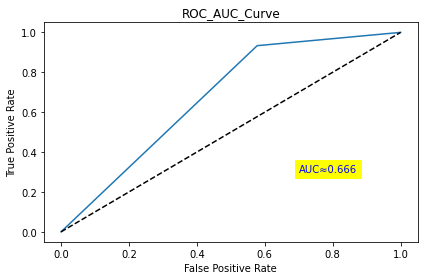

ROC_AUC_Score: 67.79%


In [ ]:
# Import logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0, solver='lbfgs') # use the default C at 1.0 indicates a default degree of regularization strength
clf.fit(x_train_balanced, y_train_balanced) # 'lbfgs’ solvers support only L2 regularization
y_test_pred = clf.predict(x_test)

# Check recall score and precision score
# Show a precision and recall metrics
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score, roc_curve, roc_auc_score

print("Recall Score","{:.2%}".format(recall_score(y_test, y_test_pred)))
print("Precision Score:","{:.2%}".format((precision_score(y_test, y_test_pred))))

# Check the ROC curve
# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC_AUC_Curve")
plt.plot([0, 1], [0, 1], "k--")
plt.text(0.7,0.3,"AUC≈0.666", color="blue", backgroundcolor="yellow")
save_fig("simple logit")
plt.show()

# Print the AUC
print("ROC_AUC_Score:","{:.2%}".format(roc_auc_score(y_test, y_test_pred)))

In [ ]:
# y_test_pred_class = clf.predict_classes(x_test, verbose=0)

# # reduce to 1-d array
# y_test_pred_class = y_test_pred_class[:,0]
# y_test_pred_class

In [ ]:
# accuracy: (tp + tn) / (p + n)
print('Accuracy for test set:', "{:.2%}".format(accuracy_score(y_test, y_test_pred)))
print('Accuracy for train set:', "{:.2%}".format(accuracy_score(y_train, clf.predict(x_train))))

# precision tp / (tp + fp)
print("Precision:", "{:.2%}".format(precision_score(y_test, y_test_pred)))


# recall: tp / (tp + fn)
print("Recall:", "{:.2%}".format(recall_score(y_test, y_test_pred)))

# f1: 2 tp / (2 tp + fp + fn)
print("F1-score:", "{:.2%}".format(f1_score(y_test, y_test_pred)))

Accuracy for test set: 43.18%
Accuracy for train set: 42.50%
Precision: 2.93%
Recall: 93.33%
F1-score: 5.68%


##### ***Random Forest***

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Recall Score 70.67%
Precision Score: 4.26%


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC_AUC_Curve')

Text(0.7, 0.3, 'AUC≈0.705')

Saving figure rfm


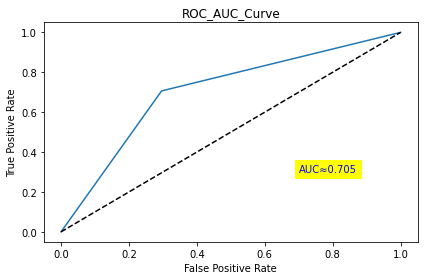

ROC_AUC_Score: 70.52%


In [ ]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Fit the RandomForestClassifier to training dataset
rfc = RandomForestClassifier()
rfc.fit(x_train_balanced, y_train_balanced)
y_test_pred = rfc.predict(x_test)

# Check recall score and precision score
# Show a precision and recall metrics
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score, roc_curve, roc_auc_score

print("Recall Score","{:.2%}".format(recall_score(y_test, y_test_pred)))
print("Precision Score:","{:.2%}".format((precision_score(y_test, y_test_pred))))

# Check the ROC curve
# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC_AUC_Curve")
plt.plot([0, 1], [0, 1], "k--")
plt.text(0.7,0.3,"AUC≈0.705", color="blue", backgroundcolor="yellow")
save_fig("rfm")
plt.show()

# Print the AUC
print("ROC_AUC_Score:","{:.2%}".format(roc_auc_score(y_test, y_test_pred)))

In [ ]:
# y_test_pred_class = rfc.predict_classes(x_test, verbose=0)

# # reduce to 1-d array
# y_test_pred_class = y_test_pred_class[:,0]
# y_test_pred_class

In [ ]:
# accuracy: (tp + tn) / (p + n)
print('Accuracy for test set:', "{:.2%}".format(accuracy_score(y_test, y_test_pred)))
print('Accuracy for train set:', "{:.2%}".format(accuracy_score(y_train, rfc.predict(x_train))))

# precision tp / (tp + fp)
print("Precision:", "{:.2%}".format(precision_score(y_test, y_test_pred)))


# recall: tp / (tp + fn)
print("Recall:", "{:.2%}".format(recall_score(y_test, y_test_pred)))

# f1: 2 tp / (2 tp + fp + fn)
print("F1-score:", "{:.2%}".format(f1_score(y_test, y_test_pred)))

Accuracy for test set: 70.38%
Accuracy for train set: 70.89%
Precision: 4.26%
Recall: 70.67%
F1-score: 8.04%


##### ***Simple Neural Networks***

In [ ]:
# Load packages
! pip install keras
from keras.models import Sequential
from keras import layers

In [ ]:
x_train_balanced.shape[1] # Number of features input

4

In [ ]:
input_dim = x_train_balanced.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, kernel_initializer = "uniform", activation='relu')) # first hidden layer
model.add(layers.Dense(12, input_dim=input_dim, kernel_initializer = "uniform", activation='relu')) # second hidden layer
model.add(layers.Dense(1, activation='sigmoid')) # output layer: use the sigmoid activation function so that you can get the probability

In [ ]:
# Use compile() to configure the learning process
# Specify the optimizer and the loss function
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                132       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train_balanced, y_train_balanced, 
                  epochs=20, verbose=False,
                  validation_data=(x_test, y_test),
                  batch_size=20)
# The batch_size represents the number of samples that will go through the neural network at each training round.
# Epochs represents the number of times that the dataset will be passed via the neural network.
# The more epochs the longer it will take to run your model, which also gives you better results.

In [ ]:
y_test_pred = model.predict(x_test)
y_test_pred = (y_test_pred > 0.5)
# I assume a probability of 50% and above to indicate a high chance of "break confidentiality".

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[2183, 1834],
       [  14,   61]])

Recall Score 81.33%
Precision Score: 3.22%


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC_AUC_Curve')

Text(0.7, 0.3, 'AUC≈0.672')

Saving figure simple ann


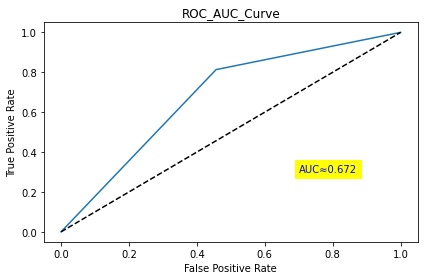

ROC_AUC_Score: 67.84%


In [ ]:
# Check recall score and precision score
# Show a precision and recall metrics
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score, roc_curve, roc_auc_score

print("Recall Score","{:.2%}".format(recall_score(y_test, y_test_pred)))
print("Precision Score:","{:.2%}".format((precision_score(y_test, y_test_pred))))

# Check the ROC curve
# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC_AUC_Curve")
plt.plot([0, 1], [0, 1], "k--")
plt.text(0.7,0.3,"AUC≈0.672", color="blue", backgroundcolor="yellow")
save_fig("simple ann")
plt.show()

# Print the AUC
print("ROC_AUC_Score:","{:.2%}".format(roc_auc_score(y_test, y_test_pred)))

In [ ]:
y_test_pred_class = model.predict_classes(x_test, verbose=0)

# reduce to 1-d array
y_test_pred_class = y_test_pred_class[:,0]
y_test_pred_class

array([0, 0, 1, ..., 0, 1, 1], dtype=int32)

In [ ]:
# accuracy: (tp + tn) / (p + n)
print('Accuracy for test set:', "{:.2%}".format(accuracy_score(y_test, y_test_pred_class)))
print('Accuracy for train set:', "{:.2%}".format(accuracy_score(y_train, model.predict_classes(x_train))))

# precision tp / (tp + fp)
print("Precision:", "{:.2%}".format(precision_score(y_test, y_test_pred_class)))


# recall: tp / (tp + fn)
print("Recall:", "{:.2%}".format(recall_score(y_test, y_test_pred_class)))

# f1: 2 tp / (2 tp + fp + fn)
print("F1-score:", "{:.2%}".format(f1_score(y_test, y_test_pred_class)))

Accuracy for test set: 54.84%
Accuracy for train set: 55.41%
Precision: 3.22%
Recall: 81.33%
F1-score: 6.19%
